In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import sys
import pandas

In [2]:
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]

In [3]:
chrn = 18

In [5]:
#fithic1 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/K562.chr'+str(chrn)+'.1Mb.spline_pass2.significances.txt.gz', skip_header=1)
#fithic2 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/prediction_K562_chr'+str(chrn)+'_down16using__home_zhangyan_SRHiC_samples_model_rebutal_model_chr1_8_9_1_5_v6782.weight.1Mb.spline_pass2.significances.txt.gz', skip_header=1)
#fithic3 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/input_K562_chr'+str(chrn)+'_down16using__home_zhangyan_SRHiC_samples_model_rebutal_model_chr1_8_9_1_5_v6782.weight.1Mb.multi16.spline_pass2.significances.txt.gz', skip_header=1)
#fithic4 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/K562_Gaussian4_chr'+str(chrn)+'.1Mb.spline_pass2.significances.txt.gz', skip_header=1)
#fithic4 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/K562_K5Gaussian4.1Mb.spline_pass2.significances.txt.gz', skip_header=1)
fithic2 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/prediction_K562_chr18_down16using__home_zhangyan_SRHiC_samples_model_downsample16_model_chr1_8_9_1_5_v1200.weight.original.spline_pass2.significances.txt.gz', skip_header=1)
fithic1 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/K562.chr18.original.spline_pass2.significances.txt.gz', skip_header=1)
fithic3 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/input_K562_chr18_down16using__home_zhangyan_SRHiC_samples_model_downsample16_model_chr1_8_9_1_5_v1200.weight.original.spline_pass2.significances.txt.gz', skip_header=1)
fithic4 = np.genfromtxt('/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/K562_Gaussian4_chr18.original.spline_pass2.significances.txt.gz', skip_header=1)


In [9]:
res=10000
chrnum = 'chr'+str(chrn)
celltype = 'K562'
fpr_all=[]
tpr_all=[]
chiapet = np.genfromtxt('/Users/linan/Dropbox/ChiAPET/'+celltype+'/'+celltype+'.CTCF.'+chrnum)
chiapet2 = np.genfromtxt('/Users/linan/Dropbox/ChiAPET/'+celltype+'/'+celltype+'.Pol2a.'+chrnum)
ctcflist_chip = pandas.read_table('/Users/linan/Dropbox/CTCF/'+celltype+'Ctcf.1bp',sep=' ', header=None)
ctcflist_chip.columns = ["chr", "pos", "direction"]
ctcflist_chip = ctcflist_chip.loc[ctcflist_chip['chr']==chrnum]
ctcflist_chip = ctcflist_chip.values
print '########Finish loading files########'
dim = chrs_length[chrn-1]/res+1
lowerb = 100000
upperb = 500000
numoffithic = 4
auc_score=np.zeros((numoffithic,100))
prc_score=np.zeros((numoffithic,100))
overlaplist=[]
for j in range(0,ctcflist_chip.shape[0]):
    chippos = ctcflist_chip[j,1]
    for i in range(0,chiapet.shape[0]):
        chiapet_1_1 = chiapet[i,1]
        chiapet_1_2 = chiapet[i,2]
        chiapet_2_1 = chiapet[i,4]
        chiapet_2_2 = chiapet[i,5]
        if chippos <= chiapet_1_2+res/2 and chippos >= chiapet_1_1-res/2:
            overlaplist.append(j)
            break
        if chippos <= chiapet_2_1+res/2 and chippos >= chiapet_2_2-res/2:
            overlaplist.append(j)
            break
'''
    for i in range(0,chiapet2.shape[0]):
        chiapet_1_1 = chiapet2[i,1]
        chiapet_1_2 = chiapet2[i,2]
        chiapet_2_1 = chiapet2[i,4]
        chiapet_2_2 = chiapet2[i,5]
        if chippos <= chiapet_1_2+res/2 and chippos >= chiapet_1_1-res/2:
            overlaplist.append(j)
            break
        if chippos <= chiapet_2_1+res/2 and chippos >= chiapet_2_2-res/2:
            overlaplist.append(j)
            break
'''
print '########Finish finding overlap between Chipseq and ChiAPET#######'
chipnotchiapet = np.delete(ctcflist_chip,overlaplist,axis=0)
print len(chipnotchiapet)
print '########Finish removing overlaps#########'
truelistloc = []
chiapet_coord = np.stack(((chiapet[:,1]+chiapet[:,2])/2/res,(chiapet[:,4]+chiapet[:,5])/2/res), axis=-1)##save chiapet in hic position to array
chiapet_nodup = np.vstack({tuple(row) for row in chiapet_coord.astype(int)})###remove multiple chiapet entry in same hic contact
print '########Finish removing redundant chiapet-hic entries########'
for chiapos in range(0,chiapet_nodup.shape[0]):
    chiapet_1 = chiapet_nodup[chiapos,0]
    chiapet_2 = chiapet_nodup[chiapos,1]
    if abs(chiapet_2*res - chiapet_1*res) > lowerb and abs(chiapet_2*res - chiapet_1*res) < upperb:
        truelistloc.append((chiapet_1,chiapet_2))
print '########Finish generating truelist########'
chipnotchiapet_nodup = np.unique(chipnotchiapet[:,1].astype(int)/res)
print len(chipnotchiapet_nodup)
print '########Finish removing redundant nonchiapet-hic entries########'
print len(truelistloc)
falselistloc = []
for o in range(0,100):
    nf = 0
    while nf <= len(truelistloc):
        b = np.random.randint(0,chipnotchiapet_nodup.shape[0],2)
        if abs(chipnotchiapet_nodup[b[0]]*res-chipnotchiapet_nodup[b[1]]*res) < upperb and abs(chipnotchiapet_nodup[b[0]]*res-chipnotchiapet_nodup[b[1]]*res) > lowerb:
            falselistloc.append((min(chipnotchiapet_nodup[b[0]],chipnotchiapet_nodup[b[1]]),max(chipnotchiapet_nodup[b[0]],chipnotchiapet_nodup[b[1]])))
            nf+=1
print '########Finish generating falselist########'
fitn = 0
for fithic in [fithic1,fithic2,fithic3,fithic4]:
    print fitn
    fithic_mat = np.zeros((dim,dim))
    for x in range(0,fithic.shape[0]):
        bin1 = int(fithic[x,1])/res
        bin2 = int(fithic[x,3])/res
        fithic_mat[bin1,bin2] = -np.log10(fithic[x,6])
    print '########Finish generating fithic matrix########'
    for q in range(0,100):
        truelist=[]
        falselist=[]
        for t in range(0,len(truelistloc)):
            truelist.append(fithic_mat[truelistloc[t][0],truelistloc[t][1]])
            falselist.append(fithic_mat[falselistloc[q*len(truelistloc)+t][0],falselistloc[q*len(truelistloc)+t][1]])
        y = np.array([1]*len(truelist)+[0]*len(falselist))
        y_score = np.array(truelist+falselist) 
        fpr_rf, tpr_rf, _ = roc_curve(y, y_score)
        fpr_all.append(fpr_rf)
        tpr_all.append(tpr_rf)
        auc_score[fitn,q]=roc_auc_score(y, y_score)
        prc_score[fitn,q]=average_precision_score(y, y_score)
    fitn += 1

########Finish loading files########
########Finish finding overlap between Chipseq and ChiAPET#######
438
########Finish removing overlaps#########
########Finish removing redundant chiapet-hic entries########
########Finish generating truelist########
382
########Finish removing redundant nonchiapet-hic entries########
169
########Finish generating falselist########
0
########Finish generating fithic matrix########
1
########Finish generating fithic matrix########
2


C:\Users\linan\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log10


########Finish generating fithic matrix########
3
########Finish generating fithic matrix########


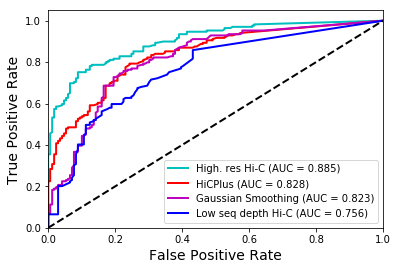

In [10]:
# Plot all ROC curves
fig = plt.figure()

plt.plot(fpr_all[2], tpr_all[2], color='c', lw=2,
             label='High. res Hi-C (AUC = {1:0.3f})'
             ''.format(2, np.mean(auc_score[0,:])))
plt.plot(fpr_all[102], tpr_all[102], color='r', lw=2,
             label='HiCPlus (AUC = {1:0.3f})'
             ''.format(102, np.mean(auc_score[1,:])))
plt.plot(fpr_all[310], tpr_all[310], color='m', lw=2,
             label='Gaussian Smoothing (AUC = {1:0.3f})'
             ''.format(310, np.mean(auc_score[3,:])))
plt.plot(fpr_all[202], tpr_all[202], color='b', lw=2,
             label='Low seq depth Hi-C (AUC = {1:0.3f})'
             ''.format(202, np.mean(auc_score[2,:])))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.legend(loc="lower right")
plt.show()

In [8]:
fig.savefig("/Users/linan/Dropbox/PSU_USC/NAR_paper/FitHiC/ROC_chr"+str(chrn)+".redo.png", dpi=1500)

In [60]:
fpr_all=np.array(fpr_all)
tpr_all=np.array(tpr_all)

In [63]:
np.save("/Users/leoli/Dropbox/PSU_USC/NAR_paper/FitHiC/fpr",fpr_all)
np.save("/Users/leoli/Dropbox/PSU_USC/NAR_paper/FitHiC/tpr",tpr_all)
np.save("/Users/leoli/Dropbox/PSU_USC/NAR_paper/FitHiC/auc",auc_score)

In [12]:
int(70.5)

70